In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic Top 4% with ensemble modeling

## 1. Introduction
* Feature analysis
* Feature engineering
* Modeling

In [2]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data

In [3]:
# 데이터 불러오기
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
IDtest = test['PassengerId']

### 2.2 Outlier detection

In [4]:
# 이상치를 찾는 함수
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25) # 1사분위수
        Q3 = np.percentile(df[col], 75) # 3사분위수
        IQR = Q3 - Q1 # 사분위범위
        
        outlier_step = 1.5 * IQR # 이상치 범위
        
        # 해당 feature에서 이상치를 가지는 인덱스 저장
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # 모든 이상치 인덱스를 oulier_indices에 추가
        outlier_indices.extend(outlier_list_col)
    
    # 이상치를 가지는 feature가 2개 이상인 인덱스를 찾음
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

# 'Age', 'SibSp', 'Parch', 'Fare'에서 이상치 찾기
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

예측(특히, 회귀분석)에 이상치가 큰 영향을 줄 수 있음
- Turky method: IQR을 사용하여 이상치 탐색

수치 변수를 가지는 Age, SibSp, Parch, Fare에서 이상치 탐지하여, 2개 이상의 컬럼에서 이상치를 가지는 index를 이상치로 간주

In [5]:
train.loc[Outliers_to_drop] # 2개 이상의 이상치를 가지는 행

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상치를 찾음
- 28, 89, 342 승객은 높은 Fare를 가지고,
- 나머지 7명의 승객은 SibSp값이 매우 높음

In [6]:
# 이상치 삭제
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

### 2.3 joining train and test set

* objs: 다중 데이터 프레임을 한 번에 합칠 때 사용

In [7]:
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True) # 행 방향으로 train, test 병합

### 2.4 check for null and missing values

In [8]:
dataset = dataset.fillna(np.nan) # 빈 값을 NaN으로 채움
dataset.isnull().sum() # 결측치 개수

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- Survived는 train에만 존재하기 때문에 test에서 결측치가 발생한 것
- Age와 Cabin에 결측치 대량 존재

In [9]:
# train 기본 정보
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
# 요약
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values

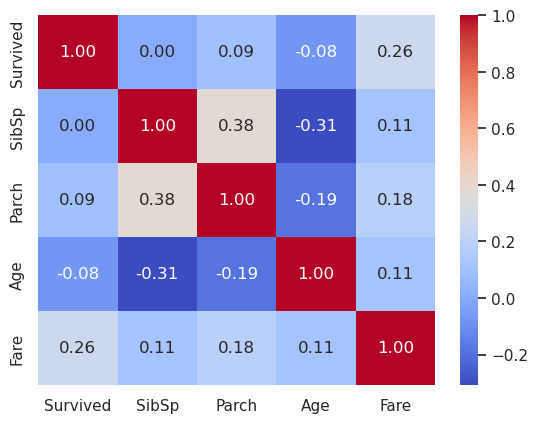

In [13]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt = '.2f', cmap='coolwarm')

Fare와 Survived만 연관이 있는 것으로 보임.

그렇다고 해서 다른 feature들이 상관없다는 것은 아님.
- 이를 확인하기 위해 feature 하나씩 살펴보아야 함.


**SibSp**

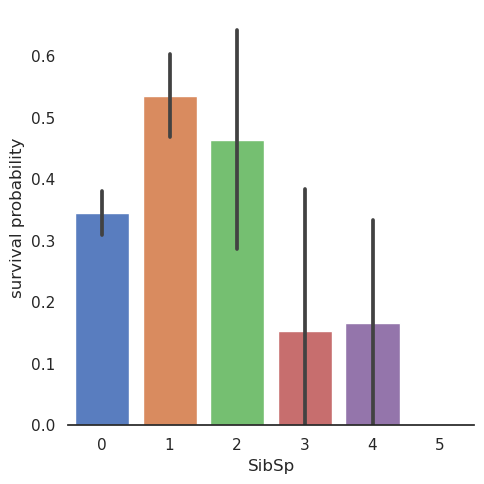

In [14]:
g = sns.catplot(x='SibSp', y='Survived', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

많은 형제/부모가 있으면 생존 확률이 낮음을 알 수 있음
- 혼자 탑승한 승객(=0) 또는 1,2명의 동승자가 있는 경우 더 높은 생존 확률을 가짐

feature engineering을 통해 이러한 카테고리의 새로운 feature를 설명할 수 있음

**Parch**

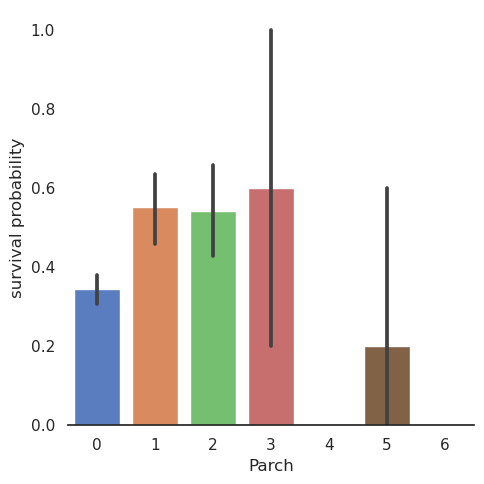

In [15]:
g = sns.catplot(x='Parch', y='Survived', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

소가족인 경우 생존 가능성이 더 높다.
- 혼자인 경우 보다(Parch = 0)
- medium families 보다 (Parch = 3, 4)
- lage families 보다 (Parch = 5, 6)

부모/자녀가 3명인 승객의 생존에 표준편차가 있음을 주의

**Age**

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


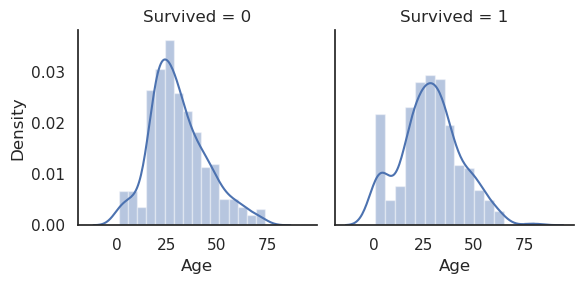

In [16]:
g = sns.FacetGrid(train, col='Survived') # col에 따른 그래프
g = g.map(sns.distplot, 'Age')

Age 분포는 꼬리가 있는 분포, 가우시안 분포로 보임
- 생존한 집단과, 생존하지 않은 집단의 연령 분포가 다름.
- 생존한 어린 승객에 해당하는 봉우리가 존재.
- 60-80세 승객들은 대부분은 생존하지 못함.

=> Age와 Survived는 상관관계가 없다고 하더라도, 승객들이 생존할 기회가 더 많거나 적은 연령대가 있음을 알 수 있음

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  This is separate from the ipykernel package so we can avoid doing imports until


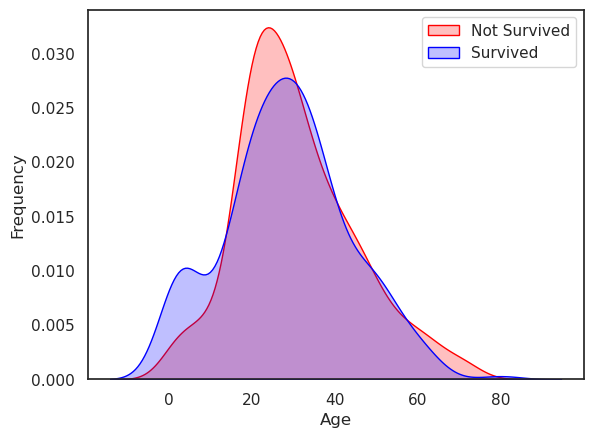

In [17]:
# Age 분포 
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

두 kde를 중접하면 어린 아이들인 0-5세에서 봉우리가 있음을 명확하게 볼 수 있음

**Fare**

In [18]:
dataset['Fare'].isnull().sum()

1

In [19]:
# 결측치를 중앙값으로 채움
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

1개의 결측치가 있지만, 중앙값으로 채워도 예측에는 큰 영향이 가지 않을 것으로 판단.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


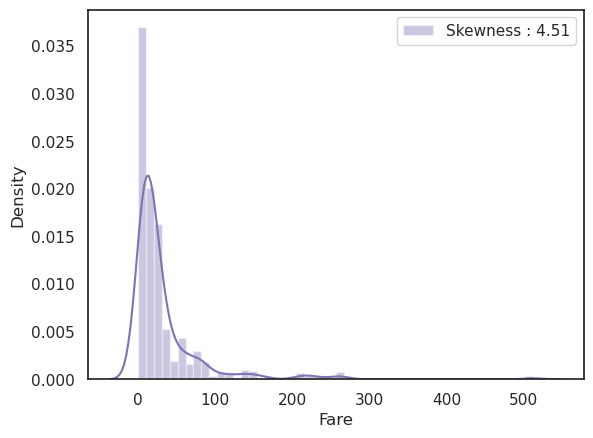

In [20]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

그래프를 보다시피, Fare는 매우 편향되어 있음
- 값을 조정하더라도, 모델에서 매우 높은 값이 초과될 수 있음
- 왜곡을 줄이기 위해 `로그함수`로 변환하는 것이 좋음

In [21]:
# 왜도 분포를 줄이기 위해 Fare에 log 함수 적용
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i>0 else 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


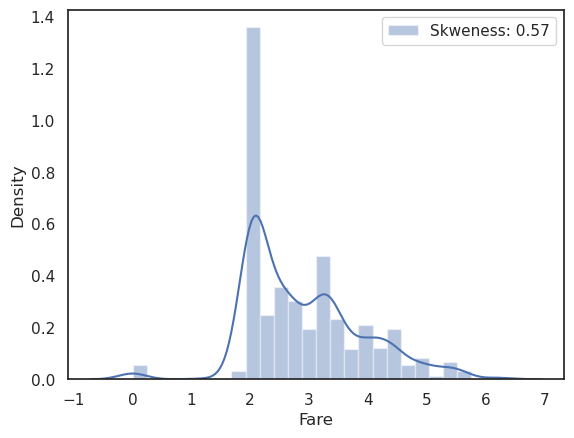

In [22]:
g = sns.distplot(dataset['Fare'], color='b', label='Skweness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

로그 변환을 통해 왜도가 확실히 줄었음

### 3.2 Categorical values

**Sex**

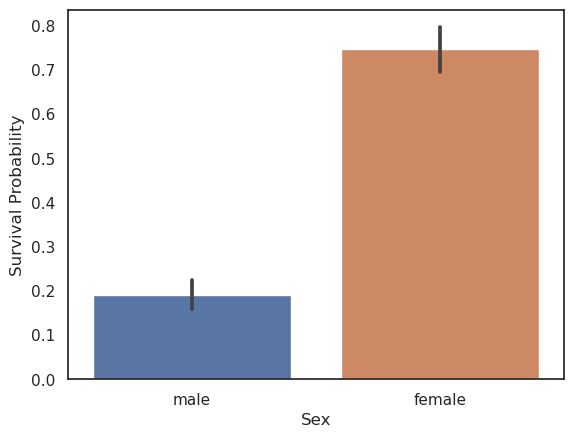

In [23]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel("Survival Probability")

In [24]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남자는 여자에 비해 생존 가능성이 적음
- Sex는 생존 예측에 있어 매우 중요한 역할


**Pclass**

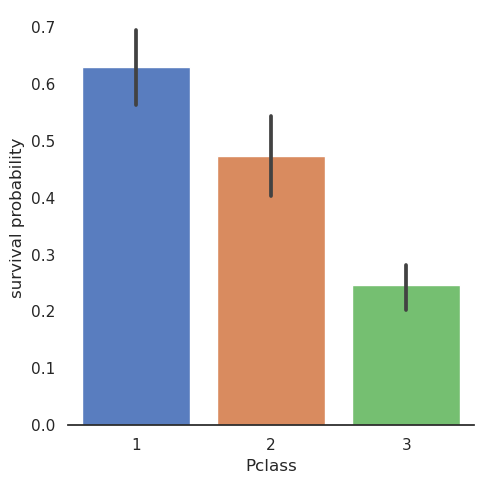

In [25]:
g = sns.catplot(x='Pclass', y='Survived', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

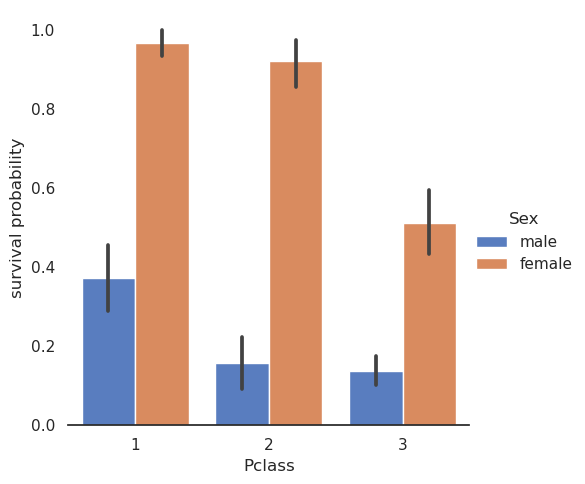

In [26]:
g = sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

3개의 등급에서 승객들의 생존은 같지 않음
- 1등석 탑승객은 2,3등석 탑승객보다 생존 가능성이 높음
- 이러한 추세는, 남여 모두에 해당 

**Embarked**

In [27]:
dataset['Embarked'].isnull().sum()

2

In [28]:
# Embarked 결측치를 가장 높은 빈도수를 가지는 'S'로 채움
dataset['Embarked'] = dataset['Embarked'].fillna('S')

Embarked 2개의 결측치를 가장 높은 빈도수를 가지는 'S'로 채움

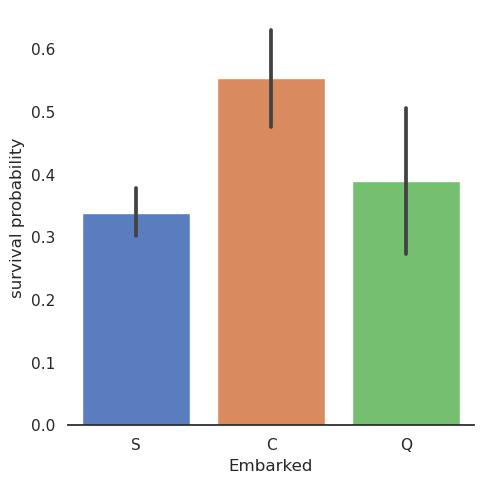

In [29]:
g = sns.catplot(x='Embarked', y='Survived', data=train, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

C 항구에서 탑승한 승객들의 생존률이 높음
- Q, S보다 C 항구에서 1등석 탑승객이 더 많이 탑승했을 것이라는 추측


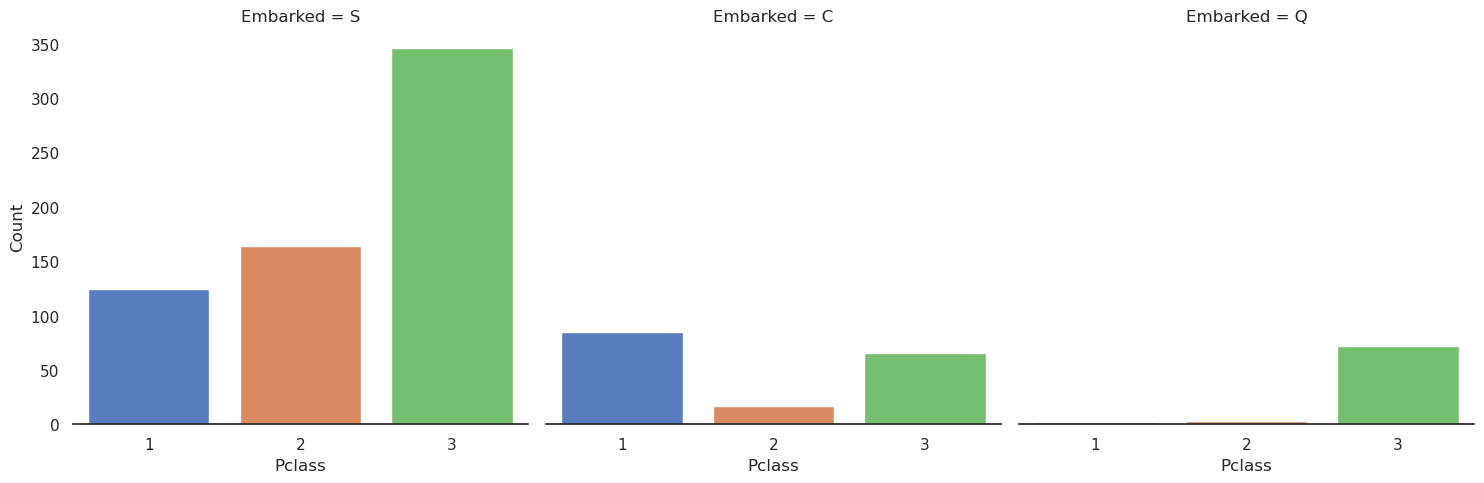

In [30]:
g = sns.catplot(x='Pclass', col='Embarked', data=train, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels("Count")

실제로, S, Q 항구에서 3등급 탑스액이 매우 많았으며, 높은 생존율를 보인 1등석 탑승객은 대부분 C 항구임을 알 수 있음 

## 4. Filling missing Values

### 4.1 Age
Age는 전체에서 256개의 결측치가 존재함
- 생존 가능성이 높은 부분집단이 존재하므로 연령 특성은 유지하되, 결측치를 대치하는 것이 좋음
- 이 문제를 해결하기 위해, Age와 관련있는 feature를 살펴봄(Sex, Parch, Pclass, SibSp)

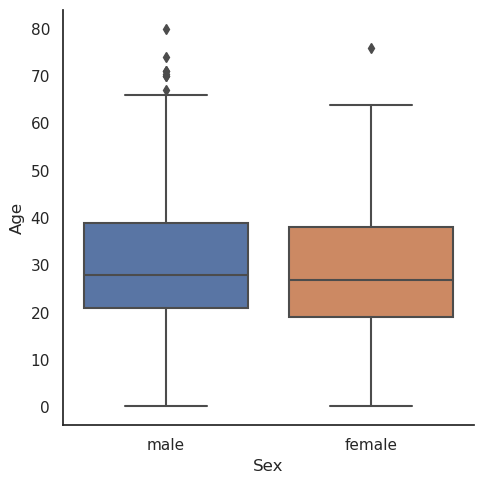

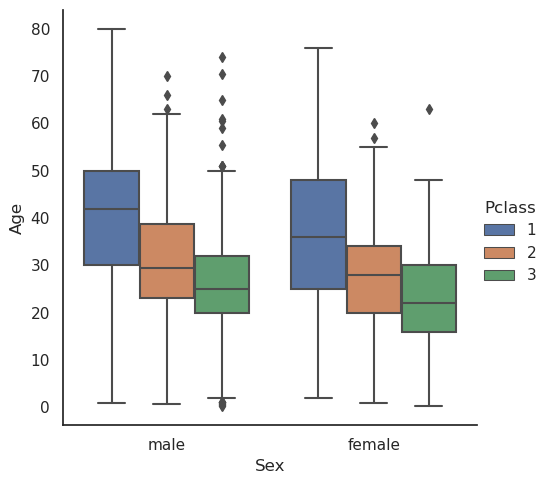

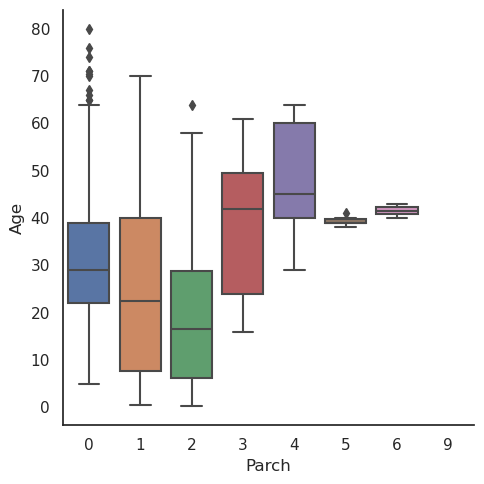

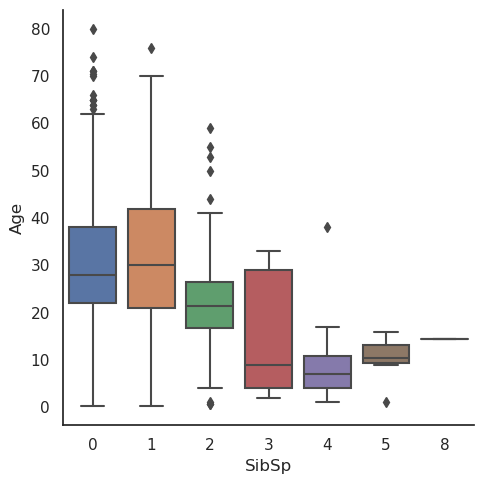

In [31]:
g = sns.catplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.catplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=dataset, kind='box')

- 남여 부분집단에서 Age 분포는 비슷해보이므로, Age 예측에 Sex는 유익하지 않음
- 1등급 승객은 2등급 승객보다 나이가 많고, 2등급 승객은 3등급 승객보다 나이가 많음
- 부모/자식이 많을 수록 본인 나이가 많고, 형제/배우자가 많을 수록 본인 나이가 적음

In [32]:
# Sex의 male, female을 각각 0,1로 바꿈
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

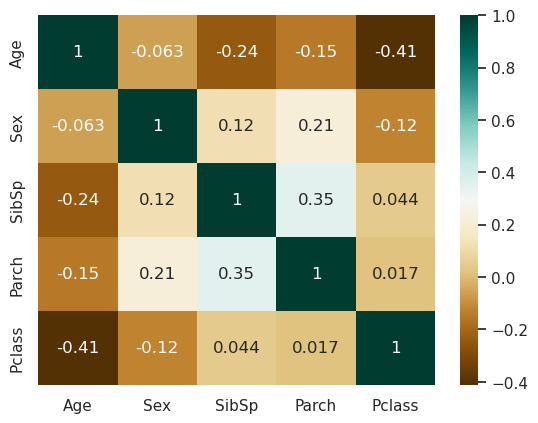

In [33]:
g = sns.heatmap(dataset[['Age', 'Sex','SibSp','Parch','Pclass']].corr(), cmap='BrBG', annot=True)

- Age는 Sex와 상관없으며, Pclass, Parch, SipSp와는 음의 상관관계를 가짐
- Age는 Parch(부모/자녀)가 커질수록 증가하지만, 일반적으로 음의 상관관계

=> 누락된 나이를 대체하기 위해 SibSp, Parch, Pclass를 사용
- Pclass, Parch, SibSp에 따라 Age의 중앙값을 구해 결측치 대체

In [34]:
# Age 결측치 채웅기
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)
for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp'])
                               & (dataset['Parch'] == dataset.iloc[i]['Parch'])
                               & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

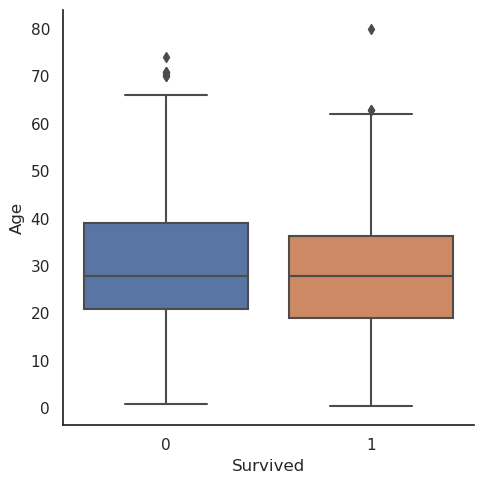

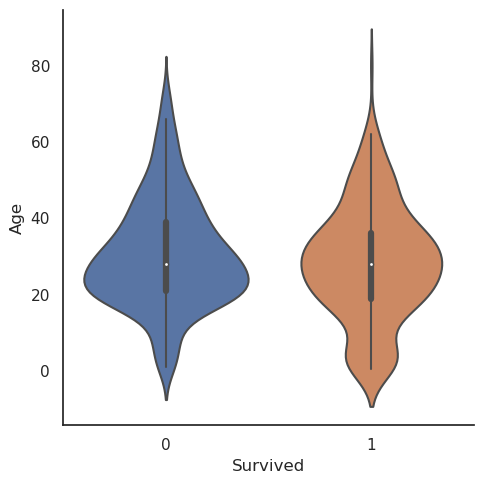

In [35]:
g = sns.catplot(x='Survived', y='Age', data=train, kind='box')
g = sns.catplot(x='Survived', y='Age', data=train, kind='violin')

생존한 집단과, 생존하지 못한 집단 간의 Age 중앙값에는 큰 차이가 없음

생존한 승객의 violinplot에서 어린 승객들이 더 높은 생존율을 가지고 있음을 알 수 있음

## 5. Feature engineering

### 5.1 Name/Title